In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from time import time

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

---

Questo notebook è presente su github al seguente link: https://github.com/guidotiana/scuolaMarche2025

---
# 1 - Percettrone

Il *percettrone* (noto anche come *neurone artificiale*) è il **blocco costitutivo** di ogni rete neurale artificiale di ultima generazione ed è composto da un vettore di pesi $\boldsymbol{w}$, un bias $b$ e una funzione di attivazione $\sigma$. Dato uno specifico input $\boldsymbol{x}$, l'output del neurone è definito come,  
$$ \hat{y}(\boldsymbol{x}) = \sigma \left( \boldsymbol{x} \cdot \boldsymbol{w} + b \right) $$
Per rallentare la saturazione della funzione di attivazione, a volte è utile anche scalare l'input di $\sigma$ con  
$$ \hat{y}(\boldsymbol{x}) = \sigma \left( \frac{\boldsymbol{x} \cdot \boldsymbol{w} + b}{\sqrt{d}} \right) $$
dove $d$ è la dimensione del vettore $\boldsymbol{x}$.

<img width="60%" src="handmade_images/Single_Perceptron.png">

Per semplicità, d'ora in poi indicherò con $\boldsymbol{w}$ tutti i parametri del percettrone (e successivamente delle reti che andremo a studiare).  
\
*Qui sotto* è presentata una possibile implementazione di un neurone, con funzione di attivazione $\sigma(\cdot) = \mathrm{tanh}(\cdot)$.

In [2]:
class Perceptron():

    def __init__(
        self,
        d,
        seed = 0,
    ):
        assert d>0, f"ValueError in {self.__class__.__name__}.__init__(): valore dell'input d={d}, ma d>0."
        self.d = round(d)
        self.seed = seed
        
        torch.manual_seed(self.seed)
        self.w = torch.randn(1, self.d, requires_grad=True)
        self.b = torch.randn(1, requires_grad=True)
        self.s = nn.Tanh()

    def forward(self, x):
        x = (self.w*x).sum(axis=-1) + self.b
        x = self.s(x/np.sqrt(self.d))
        return x

\
Proviamo ora ad ottimizzare i pesi della rete $\boldsymbol{w}$ per risolvere un problema di **classificazione**.  
Per farlo, generiamo un set di dati $\mathcal{D}$ composto da $P$ esempi (ovvero coppie input-label), dove ogni coppia è costituita da, 
$$ x_i^\mu \sim \mathcal{N}(0, 1), \,\, \forall i=1,...,d$$
$$ y^\mu \sim \frac{1}{2} \delta_{y, +1} + \frac{1}{2} \delta_{y, -1} $$
Questo tipo di dataset viene chiamato *"random label"*.

In [3]:
torch.manual_seed(4)

P, d = 8, 5
X = torch.randn(P, d)
Y = 2.*torch.randint(low=0, high=2, size=(P,)) - 1

sample = 0
print(f'Esempio:\nX[{sample}] = {X[sample].tolist()}\nY[{sample}] = {Y[sample]}')

Esempio:
X[0] = [-0.9414165019989014, 1.263246774673462, -0.18376938998699188, 0.1505054533481598, 0.10750222951173782]
Y[0] = -1.0


\
Ora possiamo definire un'istanza della nostra classe, che ottimizzeremo in base all'insieme di dati $\mathcal{D}$ che abbiamo appena generato.

In [4]:
perceptron = Perceptron(d=d, seed=16)

\
Per poter ottimizzare i parametri $\boldsymbol{w}$, abbiamo bisogno di una quantità che quantifichi quanto è lontana la previsione rispetto al valore target desiderato (cioè il label). Questa quantità viene detta **loss** e in questo caso useremo l'*errore quadratico medio* (o Mean Squared Error, MSE), definito come,  
$$ \mathcal{L}_{MSE}(\boldsymbol{w}) = \frac{1}{P} \sum_{\mu=1}^{P} \left( \hat{y}(\boldsymbol{x}^\mu) - y^\mu \right)^{2} $$
\
Inoltre, poiché in questo caso questa loss è nulla solo quando l'output della rete è esattamente uguale al label, definiremo anche una **metrica**, che conterà quante volte il *segno* della predizione *non* coincide con quello del label. Questa specifica funzione si chiama *funzione di errore* ed è definita come segue,  
$$ \epsilon(\boldsymbol{w}) = \frac{1}{P} \sum_{\mu=1}^{P} \Theta \left( - y^\mu \, \hat{y}(\boldsymbol{x}^\mu) \right) $$
dove $\Theta$ è la funzione a gradini di Heavside,
$$ \Theta(x) = \begin{cases} 1 \quad x>0\\ 0 \quad x\leq0\end{cases} $$

In [5]:
Loss = nn.MSELoss()
#def Loss(Ypred, Y):
#    return ((Ypred - Y)**2.).mean()

def Metric(Ypred, Y, k=0):
    return ((k - Ypred*Y) > 0).sum() / len(Y)

\
Ora che abbiamo definito la loss che utilizzeremo, possiamo iniziare il **training**. La tecnica più elementare è detta *discesa del gradiente* (o Gradient Descent, GD), che aggiorna il vettore dei pesi spostandolo nella direzione opposta al gradiente della loss calcolata rispetto a $\boldsymbol{w}$, ovvero
$$ \boldsymbol{w} \leftarrow \boldsymbol{w} - \eta \, \partial_\boldsymbol{w} \mathcal{L} (\boldsymbol{w})$$
dove $\eta$ è chiamato *tasso di apprendimento* (o learning rate) e definisce la lunghezza del passo dell'addestramento. 

Il gradiente di una funzione indica la *direzione* lungo la quale la funzione cresce massimamente. Di conseguenza, siccome noi vogliamo *minimizzare* il valore della loss, sposteremo i pesi della rete nella direzione *opposta* a quella indicata dal gradiente. Questo algoritmo genera una traiettoria nello spazio dei parametri $\boldsymbol{w}$ che discende la superficie della loss fino al minimo più vicino (di solito locale).  
\
*Qui sotto* segue un'implementazione dell'algoritmo GD applicato ad un percettrone.

In [6]:
def train(perc, Loss, Metric, X, Y, pars):
    history = {
        'epoch':[],
        'loss':[],
        'metric':[],
    }
    
    for epoch in range(pars['epochs']+1):
        Ypred = perc.forward(X)
        loss = Loss(Ypred, Y)
        metric = Metric(Ypred, Y)
        history['epoch'].append(epoch)
        history['loss'].append(loss.item())
        history['metric'].append(metric.item())
        if epoch < pars['epochs']:
            loss.backward()
            step(perc, pars['lr'])
    
    return history


def step(perc, lr=1.):
    if (perc.w.grad is not None) & (perc.b is not None):
        with torch.no_grad():
            perc.w -= lr*perc.w.grad
            perc.b -= lr*perc.b.grad
        perc.w.grad = None
        perc.b.grad = None

In [7]:
%%time
pars = {
    'epochs': 10000,
    'lr': 0.001,
}
history = train(perceptron, Loss, Metric, X, Y, pars)

CPU times: user 872 ms, sys: 2.32 ms, total: 874 ms
Wall time: 873 ms


\
Plottiamo ora lo storico dei valori della loss e della metrica lungo il training.

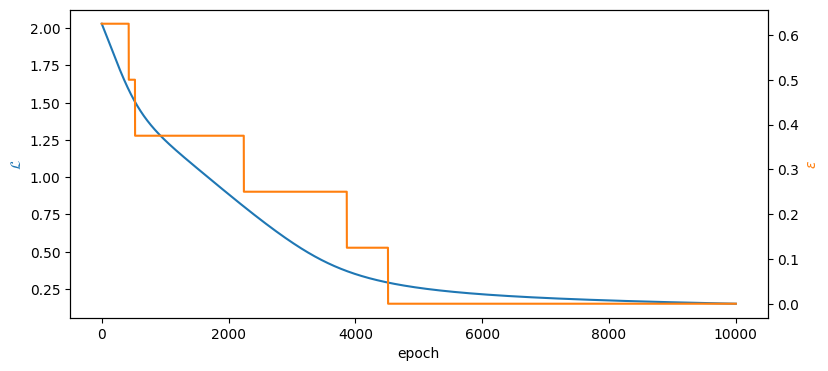

In [8]:
fig, ax = plt.subplots(figsize=(9, 4))

ax.plot(history['epoch'], history['loss'], color='#1f77b4')
ax.set_ylabel(r'$\mathcal{L}$', color='#1f77b4')
ax.set_xlabel('epoch')

tax = ax.twinx()
tax.plot(history['epoch'], history['metric'], color='#ff7f0e')
tax.set_ylabel(r'$\epsilon$', color='#ff7f0e');

\
Abbiamo addestrato un perceptron con $N=6$ parametri (tenendo conto anche del bias) su un set di dati composto da $P=8$ esempi e, alla fine del training, il modello è stato in grado di prevedere correttamente il segno del label corrispondente a ciascun esempio.  
\
Naturalmente, esiste un limite alla quantità di informazioni che il percettrone può memorizzare, ovvero esiste un numero massimo di esempi $P_C$ tale che,  
$$ \forall \, P > P_C, \, \epsilon(\boldsymbol{w}) > 0 \,\, \forall \boldsymbol{w} \in \mathbb{R}^{d} $$
cioè non è più possibile trovare un vettore di pesi a cui sia associato un errore nullo.  

Questo fatto viene solitamente espresso in termini di una variabile $\alpha \equiv P/N$. In particolare, per un percettrone di $N$ gradi di libertà e un insieme di $P$ label "casuali" (come quelli che abbiamo appena utilizzato), il valore critico è noto. *Trovatelo!*

### ESERCIZIO:
- selezionare alcuni valori di $\alpha$ (mantenendo fissa la dimensione dell'input $d$) (suggerimento: usare $\alpha \approx 1, 2, 3$);
- per ogni $\alpha$, eseguire vari training (inizializzando in modo diverso i pesi del percettrone, cioè cambiando il seed) e salvare l'errore minimo trovato fra tutte le sessioni effettuate;
- tracciare il grafico dell'errore di training minimo in funzione di $\alpha$.

### Soluzione:

In [9]:
%%time
pars = {
    'epochs': 10000,
    'lr': 0.05,
}

d = 9  #N = d+1 = 10
P_list = [10, 15, 20, 25, 30]

num_training = 10
df = {'alpha':[], 'error_fraction':[], 'error_number':[]}

t0 = time()
print("# Training:")
for iP, P in enumerate(P_list):    
    torch.manual_seed(iP)
    X = torch.randn(P, d)
    Y = 2.*torch.randint(low=0, high=2, size=(P,)) - 1

    alpha = P/(d+1.)
    error_fraction = 1.
    print(f"alpha={format(alpha,'.1f')} -> ", end='')
    for it in range(num_training):
        perceptron = Perceptron(d=d, seed=iP+it+1)
        history = train(perceptron, Loss, Metric, X, Y, pars)
        error_fraction = min([error_fraction, history['metric'][-1]])
    error_number = round(error_fraction*P)

    df['alpha'].append(alpha)
    df['error_fraction'].append(error_fraction)
    df['error_number'].append(error_number)

    print(f"error={format(error_fraction, '.3f')} ({error_number}/{P})\t(t={format(time()-t0, '.1f')})")
print()

# Training:
alpha=1.0 -> error=0.000 (0/10)	(t=8.6)
alpha=1.5 -> error=0.000 (0/15)	(t=17.4)
alpha=2.0 -> error=0.050 (1/20)	(t=27.0)
alpha=2.5 -> error=0.040 (1/25)	(t=36.5)
alpha=3.0 -> error=0.300 (9/30)	(t=46.0)

CPU times: user 45.9 s, sys: 8.16 ms, total: 45.9 s
Wall time: 46 s


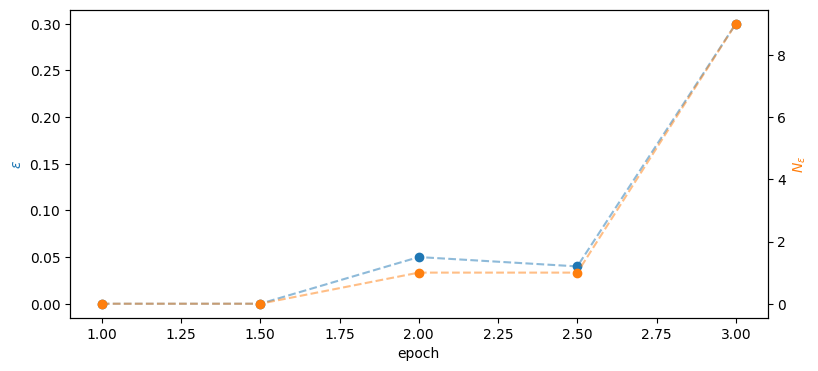

In [10]:
fig, ax = plt.subplots(figsize=(9, 4))

ax.scatter(df['alpha'], df['error_fraction'], color='#1f77b4')
ax.plot(df['alpha'], df['error_fraction'], linestyle='--', alpha=0.5, color='#1f77b4')
ax.set_ylabel(r'$\epsilon$', color='#1f77b4')
ax.set_xlabel('epoch')

tax = ax.twinx()
tax.scatter(df['alpha'], df['error_number'], color='#ff7f0e')
tax.plot(df['alpha'], df['error_number'], linestyle='--', alpha=0.5, color='#ff7f0e')
tax.set_ylabel(r'$N_{\epsilon}$', color='#ff7f0e');

---
# 2- Multi-Layer Perceptron (MLP): regressione

Consideriamo ora un altro tipo di problema: la **regressione**.   
Supponiamo di avere un insieme di misure di una coppia di variabili, $x$ e $y$. Provare ad identificare la relazione tra di esse significa identificare la funzione $f$ t.c. $y = f(x)$. Inoltre, possiamo anche immaginare che i valori ottenuti dalle misure sperimentali saranno soggetti ad errori.  
\
Tenendo presente tutto ciò, possiamo provare a replicare artificialmente questo scenario, generando un set di dati a partire da una funzione nota ed aggiungendoci sopra un certo rumore. Le coppie input-label saranno quindi qualcosa del genere,
$$ y^\mu = f(x^\mu) + \epsilon, \,\, \forall \, \mu=1,...,P $$  
dove 
$$ \epsilon \sim \mathcal{N}(0, \sigma^2) $$
rappresenta il rumore sperimentale (che assumiamo sia distribuito gaussianamente).

In [11]:
class CustomDataset(Dataset):
    
    def __init__(
        self,
        func,
        fpars,
        xlims,
        P,
        noise_std = 1.,
        seed = 0,
    ):
        super(CustomDataset, self).__init__()
        self.func = func
        self.fpars = fpars
        (self.xmin, self.xmax) = xlims
        self.P = P
        self.noise_std = noise_std
        self.seed = seed
        
        self.Xtrue = torch.linspace(self.xmin, self.xmax, self.P).unsqueeze(1)
        self.Ytrue = self.func(self.Xtrue, **self.fpars)
        
        torch.manual_seed(self.seed)
        self.X = (self.xmax-self.xmin)*torch.rand(self.P, 1) + self.xmin
        self.Y = self.func(self.X, **self.fpars) + self.noise_std*torch.randn(self.P, 1)

    def __len__(self):
        return self.P

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

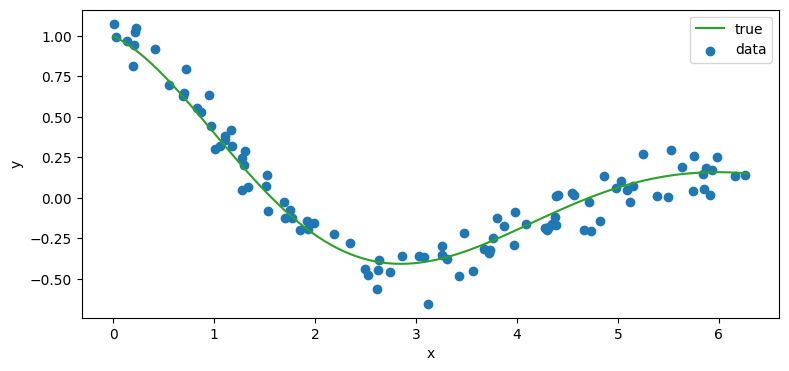

In [12]:
def func(x, **fpars):
    return torch.cos(x) * torch.exp(-fpars['lamda']*x)

fpars = {'lamda': 0.3}
train_xlims = [0., 2.*np.pi]
P = 100
noise_std = 0.1
seed = 0

train_dataset = CustomDataset(
    func=func,
    fpars=fpars,
    xlims=train_xlims,
    P=P,
    noise_std=noise_std, 
    seed=seed
)

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(train_dataset.Xtrue.reshape(-1), train_dataset.Ytrue.reshape(-1), color='#2ca02c', label='true')
ax.scatter(train_dataset.X.reshape(-1), train_dataset.Y.reshape(-1), color='#1f77b4', label='data')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='upper right');

\
Per un compito del genere, dovremo implementare un'architettura più elaborata, un **Multi-Layer Perceptron** (MLP).  
Quest'ultimo è generalmente composto da $L$ layer, ognuno dei quali contiene $n_l$ percettroni che prendono come input l'output dei neuroni dello strato precedente.

<img width="80%" src="handmade_images/MLP.png">

Ciò significa che l'output dell'$i$-esimo neurone del layer $l$ è la seguente,
$$ a_i^{(l)} = \sigma^{(l)} \left[ \sum_{j=1}^{n_{l-1}} a_j^{(l-1)} w_{ij}^{(l)} \right] \quad \forall \, i=1,...,n_l$$
dove $\boldsymbol{a}^0 = \boldsymbol{x}$ (ovvero il dato di input) and $\boldsymbol{a}^L = \boldsymbol{\hat{y}}$ (cioè l'output della rete).

*Qui sotto* è presente una implementazione di una MLP, dove tutti i neuroni hanno la stessa funzione di attivazione, chiamata ReLU,
$$ \mathrm{ReLU}(x) = \begin{cases} x \quad x \geq 0\\ 0 \quad x<0\end{cases} $$

In [13]:
class RegressionMLP(nn.Module):

    def __init__(
        self, 
        input_size, 
        hidden_sizes, 
        output_size,
        seed = 0
    ):
        super(RegressionMLP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        self.reset(seed)

    def reset(self, seed=0):
        self.seed = seed
        torch.manual_seed(self.seed)

        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()
        in_size = input_size
        sizes = hidden_sizes + [output_size]
        for ilayer, out_size in enumerate(sizes):
            layer = nn.Linear(in_features=in_size, out_features=out_size, bias=True)
            activation = nn.ReLU() if ilayer<len(sizes)-1 else nn.Identity()
            self.layers.append(layer)
            self.activations.append(activation)
            in_size = out_size
    
    def forward(self, x):
        for layer, activation in zip(self.layers, self.activations):
            x = layer(x)
            x = activation(x)
        return x

In [14]:
input_size = train_dataset.X.shape[-1]
hidden_sizes = [64, 64]
output_size = train_dataset.Y.shape[-1]

rmlp = RegressionMLP(
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    output_size=output_size,
)

\
Per affrontare questo problema di regressione, andremo ad utilizzare la stessa loss precedente, ovvero la MSE.  
\
Al contrario, vorremmo cercare di migliorare il metodo di apprendimento utilizzato in precedenza per il percettrone. Per esempio, se la dimensione $P$ del dataset è molto alta, calcolare il gradiente della loss su *tutti* i dati è computazionalmente molto costoso. Una alternativa immediata è, quindi, calcolare il gradiente solo rispetto a *pochi* dati alla volta.  
\
Nella pratica , ad ogni epoca:
- il dataset viene suddiviso in sottoinsiemi di dimensione ridotta (chiamati **mini-batches**), ovvero contenenti pochi esempi;
- per ciascuno di questi sottoinsiemi, i parametri della rete vengono aggiornati per migliorare la predizione della rete *solo sugli esempi contenuti nel mini-batch*;
- una volta che tutti i mini-batch sono stati utilizzati, l'epoca corrente termina ed inizia la successiva, fino alla fine del training.

Questo algoritmo è chiamato *Stochastic Gradient Descent* (SGD).  
\
*Qui di seguito* è presente una implementazione dell'algoritmo SGD su una generale rete neurale.

In [15]:
def train(model, Loss, dataloader, optimizer, pars):
    history = {
        'epoch':[],
        'loss_mean':[],
        'loss_std':[],
    }
    #model.to(pars['device']

    model.train()
    for epoch in range(1, pars['epochs']+1):
        
        loss_list = []
        for x, y in dataloader:
            optimizer.zero_grad()
            #x, y = x.to(device), y.to(device)
            ypred = model(x)
            loss = Loss(ypred, y)
            loss_list.append(loss.item())
            loss.backward()
            optimizer.step()
        
        history['epoch'].append(epoch)
        history['loss_mean'].append(np.mean(loss_list))
        history['loss_std'].append(np.std(loss_list))

    for key in history:
        history[key] = np.array(history[key])
    return history

In [16]:
%%time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pars = {
    'epochs': 2000,
    'lr': 0.001,
    'weight_decay': 0.,
    'batch_size': 32,
    'device': device,
}

Loss = nn.MSELoss()
train_dataloader = DataLoader(train_dataset, batch_size=pars['batch_size'], shuffle=True)
optimizer = optim.SGD(rmlp.parameters(), lr=pars['lr'], weight_decay=pars['weight_decay'])

history = train(rmlp, Loss, train_dataloader, optimizer, pars)

CPU times: user 1min 16s, sys: 49.6 ms, total: 1min 16s
Wall time: 7.68 s


\
Come prima, tracciamo lo storico della loss media in ciascuna epoca lungo il training.

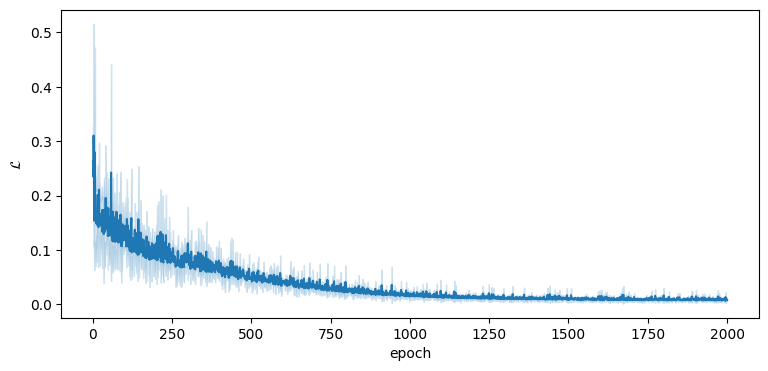

In [17]:
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(history['epoch'], history['loss_mean'], color='#1f77b4')
ax.fill_between(history['epoch'], history['loss_mean']-history['loss_std'], history['loss_mean']+history['loss_std'], color='#1f77b4', alpha=0.2)
ax.set_ylabel(r'$\mathcal{L}$')
ax.set_xlabel('epoch');

\
Verifichiamo ora che il modello abbia effettivamente imparato la relazione tra la variabile $x$ ed $y$.

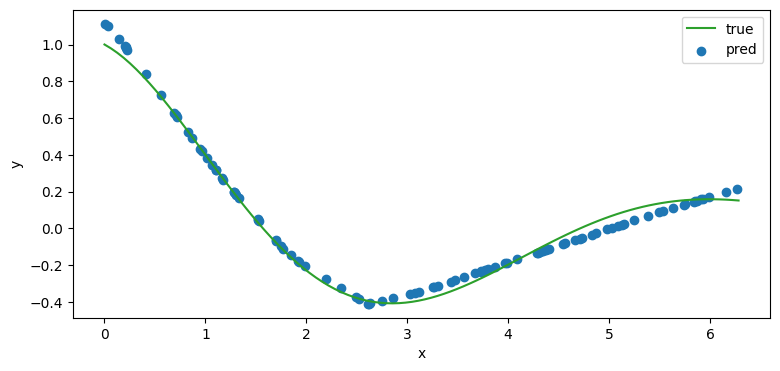

In [18]:
rmlp.eval()
with torch.no_grad():
    train_Ypred = rmlp(train_dataset.X).detach().numpy()

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(train_dataset.Xtrue.reshape(-1), train_dataset.Ytrue.reshape(-1), color='#2ca02c', label='true')
ax.scatter(train_dataset.X.reshape(-1), train_Ypred.reshape(-1), color='#1f77b4', label='pred')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='upper right');

### ESERCIZIO (1):
- ripetere il processo di training usando due ottimizzatori diversi, SGD e Adam;
- confrontare lo storico di ciascuno dei due training e le previsioni fatte dai due modelli finali.

### ESERCIZIO (2):
- generare un nuovo set di dati, utilizzando la stessa funzione ma modificando il dominio da cui si estraggono i dati;
- per ciascuno dei due modelli addestrati, confrontare la funzione vera $f$ con la previsione del modello quando l'input non rientra nel dominio su cui è stato effettuato il training.

### Soluzione (1):

In [19]:
%%time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pars = {
    'epochs': 2000,
    'lr': 0.001,
    'weight_decay': 0.,
    'batch_size': 32,
    'device': device,
}

Loss = nn.MSELoss()
train_dataloader = DataLoader(train_dataset, batch_size=pars['batch_size'], shuffle=True)

SGD_rmlp = RegressionMLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size, seed=17)
optimizer = optim.SGD(SGD_rmlp.parameters(), lr=pars['lr'], weight_decay=pars['weight_decay'])
SGD_history = train(SGD_rmlp, Loss, train_dataloader, optimizer, pars)

Adam_rmlp = RegressionMLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size, seed=1)
optimizer = optim.SGD(Adam_rmlp.parameters(), lr=pars['lr'], weight_decay=pars['weight_decay'])
Adam_history = train(Adam_rmlp, Loss, train_dataloader, optimizer, pars)

CPU times: user 2min 43s, sys: 73 ms, total: 2min 43s
Wall time: 16.4 s


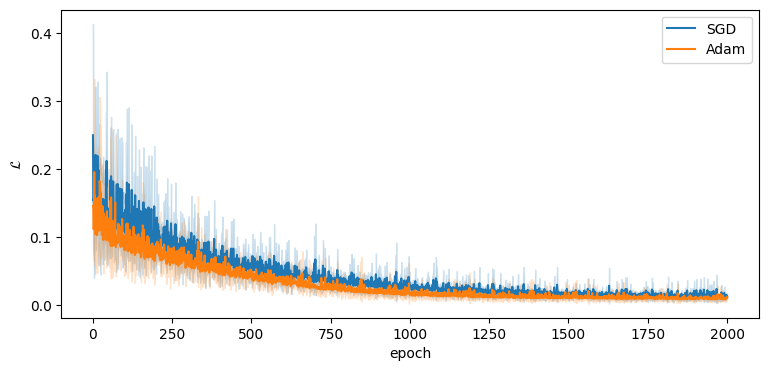

In [20]:
fig, ax = plt.subplots(figsize=(9, 4))
for history, label, color in zip((SGD_history, Adam_history), ('SGD', 'Adam'), ('#1f77b4', '#ff7f0e')):
    ax.plot(history['epoch'], history['loss_mean'], color=color, label=label)
    ax.fill_between(history['epoch'], history['loss_mean']-history['loss_std'], history['loss_mean']+history['loss_std'], color=color, alpha=0.2)
ax.set_ylabel(r'$\mathcal{L}$')
ax.set_xlabel('epoch')
ax.legend(loc='upper right');

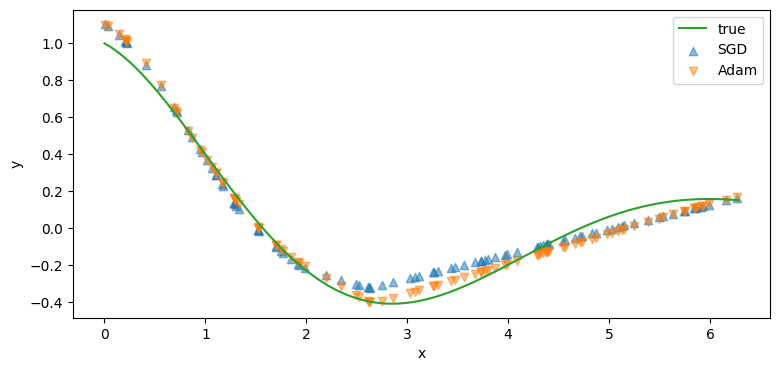

In [21]:
fig, ax = plt.subplots(figsize=(9, 4))

ax.plot(train_dataset.Xtrue.reshape(-1), train_dataset.Ytrue.reshape(-1), color='#2ca02c', label='true')
for rmlp, label, color, marker in zip((SGD_rmlp, Adam_rmlp), ('SGD', 'Adam'), ('#1f77b4', '#ff7f0e'), ('^', 'v')):
    rmlp.eval()
    with torch.no_grad():
        train_Ypred = rmlp(train_dataset.X).detach().numpy()
    ax.scatter(train_dataset.X.reshape(-1), train_Ypred.reshape(-1), color=color, marker=marker, alpha=0.5, label=label)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='upper right');

### Soluzione (2):

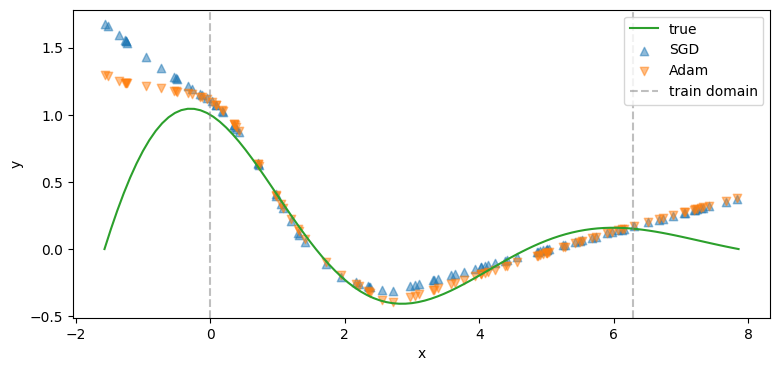

In [22]:
test_xlims = [-np.pi/2., 2.*np.pi+np.pi/2.]  
test_dataset = CustomDataset(
    func=func,
    fpars=fpars,
    xlims=test_xlims,
    P=P,
    noise_std=noise_std, 
    seed=seed
)

fig, ax = plt.subplots(figsize=(9, 4))

ax.plot(test_dataset.Xtrue.reshape(-1), test_dataset.Ytrue.reshape(-1), color='#2ca02c', label='true')
for rmlp, label, color, marker in zip((SGD_rmlp, Adam_rmlp), ('SGD', 'Adam'), ('#1f77b4', '#ff7f0e'), ('^', 'v')):
    rmlp.eval()
    with torch.no_grad():
        test_Ypred = rmlp(test_dataset.X).detach().numpy()
    ax.scatter(test_dataset.X.reshape(-1), test_Ypred.reshape(-1), color=color, marker=marker, alpha=0.5, label=label)

for ix, xlim in enumerate(train_xlims):
    label = 'train domain' if ix==0 else None
    ax.axvline(xlim, color='gray', linestyle='--', alpha=0.5, label=label)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='upper right');

---
# Multi-Layer Perceptron (MLP): classificazione

Torniamo ora ad un problema di classificazione. In questa sezione, useremo il dataset **MNIST** (Modified National Institute of Standards and Technology database), un grosso database di cifre (numeri tra 0 e 9) scritte a mano, contenente 60,000 immagini di training e 10,000 di test.

Questo dataset viene comunemente utilizzato per allenare reti che processano immagini e può essere facilmente scaricato con <font face = "Courier"> `torchvision.datasets`</font>. Questo è solo uno dei numerosi set di dati (composti da immagini e corrispondenti label) disponibili tramite torchvision (per più informazioni, guardate <a href="https://pytorch.org/vision/main/datasets.html"> qui</a>).

In [23]:
path = 'MNIST'
if path not in os.listdir('.'):
    os.mkdir(path)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(
    path,
    train=True,
    download=True,
    transform=transform
)
test_dataset = datasets.MNIST(
    path,
    train=False,
    transform=transform
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:25<00:00, 393kB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 137kB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:04<00:00, 336kB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 166kB/s]


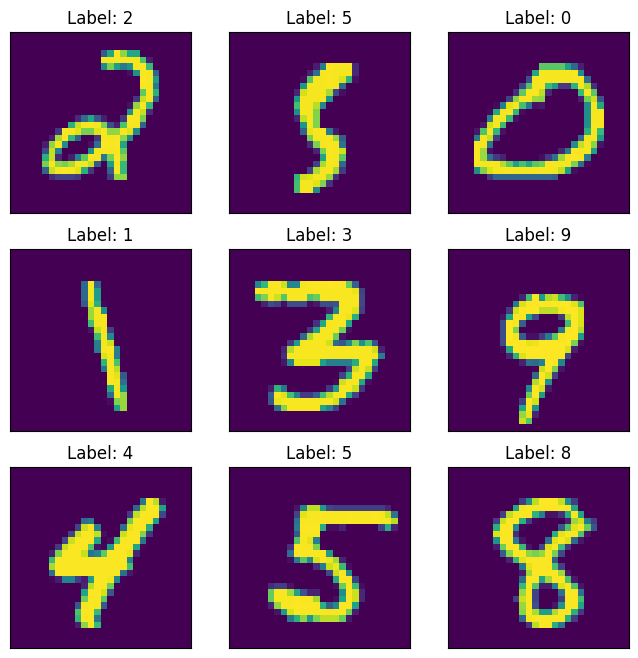

In [24]:
torch.manual_seed(7)

fig, axs = plt.subplots(figsize=(8, 8), ncols=3, nrows=3)
for ax in axs.reshape(-1):
    idx = torch.randint(low=0, high=len(train_dataset), size=(1,))
    img, lab = train_dataset.data[idx][0], train_dataset.targets[idx][0].item()
    ax.set_title(f'Label: {lab}')
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

Essenzialmente, il dataset in questo caso è composto da coppie immagine-label $(\boldsymbol{x}^\mu, y^\mu)$, dove ciascuna coppia è,
$$ \boldsymbol{x}^\mu \in \mathbb{N}^{28 \mathrm{x} 28} $$
$$ y^\mu \in \{0, 1, ..., 9\} $$
Esprimere il label come un numero intero compreso fra $0$ e $9$ può essere un problema, in quanto da uno specifico ordine a dei label che però no dovrebbero averlo. Per esempio, se l'input è una immagine rappresentante la cifra $5$, predire $4$ è tanto sbagliato quanto predire $9$.  
\
Per eliminare questo problema, la soluzione più comune è quella di rappresentare ciascun label intero come un vettore composto di soli $0$ tranne sull'indice corrispondente al label. Ovvero,
$$ y^\mu = 0 \quad \rightarrow \quad \overline{y}_i^\mu = \left( 1, 0, 0, ... 0 \right)$$
$$ y^\mu = 1 \quad \rightarrow \quad \overline{y}_i^\mu = \left( 0, 1, 0, ... 0 \right)$$
$$ y^\mu = 2 \quad \rightarrow \quad \overline{y}_i^\mu = \left( 0, 0, 1, ... 0 \right)$$
e così via.  
\
Utilizzare questa notazione vuol dire che l'ouput della rete neurale dovrà essere un vettore $\boldsymbol{\hat{y}}(\boldsymbol{x}^\mu)$ di dimensione pari al numero delle classi (in questo caso $10$) che sarà interpretata come una distribuzione di probabilità,
$$ \sum_{i=1}^{10} \hat{y}^\mu_{i} = 1 $$
$$ \hat{y}^\mu_{i} \geq 0 $$

\
*Nelle celle seguenti, troverete del codice incompleto, che dovrete completare adeguatamente per riolvere questo problema di classificazione. Non preoccupatevi, nelle celle sono presenti anche dei consigli su cosa fare!*  
1. Il primo passo è quello di trsformare la precedente classe <font face = "Courier"> `RegressionMLP`</font> in <font face = "Courier"> `ClassificationMLP`</font> per poterla applicare a questo problema. Ricordatevi che la principale differenza è che l'ouput dovrà essere un vettore di probabilità!

In [ ]:
class ClassificationMLP(nn.Module):

    def __init__(
        self, 
        input_size, 
        hidden_sizes, 
        output_size,
        seed = 0
    ):
        super(ClassificationMLP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        self.reset(seed)

    def reset(self, seed=0):
        # TODO:
        # La classe è fondamentalmente uguale a quella precedente, MA attenzione: 
        # è una classificazione con 10 classi, l'output dovrà essere diverso!
        # Suggerimento: modificate l'ultima funzione di attivazione!
        
        self.seed = seed
        torch.manual_seed(self.seed)
        ...
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        for layer, activation in zip(self.layers, self.activations):
            x = layer(x)
            x = activation(x)
        return x

In [ ]:
input_size = ...     #COMPLETARE!
hidden_sizes = ...   #COMPLETARE! Raccomandazione: non usate troppi layer (il training risultante sarà più lento)
output_size = ...    #COMPLETARE!

cmlp = ClassificationMLP(
    input_size=input_size, 
    hidden_sizes=hidden_sizes,
    output_size=output_size,
)

Come al solito, per poter allenare la rete, è necessario definire una funzione di loss e una metrica (dal momento che stiamo effettuanto una classificazione).

Iniziamo dalla *loss*. Una possibile scelta è, nuovamente, la MSE, che dovremo modificare leggermente per poterlo applicare a dei vettori (anzichè a degli scalari),
$$ \mathcal{L}_{MSE}(\boldsymbol{w}) = \frac{1}{P} \sum_{\mu=1}^{P} \left[ \sum_{i=1}^{10} \left( \hat{y}_i(\boldsymbol{x}^\mu) - \overline{y}_i^\mu \right)^{2} \right] $$
Il problema di questa funzione è che non sfrutta il fatto che $\boldsymbol{\hat{y}}(\boldsymbol{x}^\mu)$ ed $\boldsymbol{\overline{y}}^\mu$ non sono semplicemente vettori, ma sono *vettori normalizzati* (cioè possono essere interpretati come distribuzioni di probabilità). Per questo motivo, la scelta tipica per problemi di classificazione non ricade sulla MSE ma sulla **catgorical cross-entropy** (o **negative log-likelihood**), che è la seguente,
$$ \mathcal{L}_{NLL}(\boldsymbol{w}) = - \frac{1}{P} \sum_{\mu=1}^{P} \left[ \sum_{i=1}^{10} \, \overline{y}_i^\mu \, \mathrm{log} \left[ \hat{y}_i(\boldsymbol{x}^\mu) \right] \right] $$  
\
Per quanto invece riguarda la *metrica*, la funzione che utilizzeremo sarà nuovamente la funzione di errore. Tuttavia siccome i label non sono più $\pm 1$, dobbiamo ridefinire cosa consideriamo un output *corretto*. In questo caso, la predizione sarà soddisfacente se *la classe più probabile* secondo la rete *è effettivamente quella corretta*. L'equazione modificata che descrive questa funzione di errore è la seguente,
$$ \epsilon(\boldsymbol{w}) = \frac{1}{P} \sum_{\mu=1}^{P} \left[ 1 - \delta_{k^\mu, y^\mu} \right] $$
dove,
$$ k^\mu \equiv \mathrm{argmax}_{i} \, \hat{y}_i(\boldsymbol{x}^\mu) $$
\
*Qui sotto* segue l'implementazione di entrambe le loss e della metrica di errore.

In [ ]:
def MSE_Loss(ypred, y):
    ohe_y = F.one_hot(y, num_classes=output_size)
    return ((ohe_y - ypred)**2.).sum(axis=-1).mean()

def NLL_Loss(ypred, y):
    return F.nll_loss(torch.log(ypred), y)

def Metric(ypred, y):
    yargmax = ypred.argmax(dim=-1)
    return y.eq(yargmax).sum() / len(y)

\
2. Una volta che la rete è pronta ed abbiamo definito le varie funzioni (loss e metrica), dobbiamo implementare il processo di training. La differenza principale con la precedente funzione <font face = "Courier"> `train`</font> è che in questo caso abbiamo due set di dati, quello di *train*, su cui vogliamo ottimizare i parametri (ovvero, calcolare il gradiente e spostare i paramentri nella direzione opposta) e quello di *test*, da utilizzare solo per verificare che il modello sia in grado di predirre correttamente il label di immagini che **non** ha ancora visto.

In [ ]:
def train(...):
    history = {
        'train': {
            'epoch':[],
            'loss_mean':[],
            'loss_std':[],
            'metric_mean': [],
            'metric_std': [],
        },
        'test': {
            'epoch': [],
            'loss': [],
            'metric': [],
        }
    }
    
    for epoch in range(1, pars['epochs']+1):
        step(...)      #COMPLETARE!
        evaluate(...)  #COMPLETARE!

    return history


def step(...):
    # TODO:
    # 1- Preparare una lista della quantità da misurare;
    # 2- Ciclare sui minibatch del dataset di training e per ciascuno:
    #    - azzerare il gradiente dei parametri della rete;
    #    - calcolare le quantità da misurare;
    #    - aggiornare i pesi della rete;
    # 3- Terminati i minibatch, aggiornare lo storico del training.
    
    model.train()
    ...


def evaluate(...):
    # TODO:
    # 1- Porre a zero le quantità da misurare;
    # 2- Ciclare sui minibatch del dataset di test e per ciascuno:
    #    - calcolare le quantità da misurare (SENZA calcolare il gradiente ed aggiornare i pesi)
    # 3- Terminati i minibatch, aggiornare lo storico del test.
    
    model.eval()
    with torch.no_grad():
        ...

In [ ]:
%%time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pars = {
    'epochs': 10,
    'lr': 0.001,
    'weight_decay': 0.,
    'batch_size': 64,
    'device': device,
}
    
train_dataloader = DataLoader(train_dataset, batch_size=pars['batch_size'], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=pars['batch_size'], shuffle=True)
optimizer = optim.SGD(cmlp.parameters(), lr=pars['lr'], weight_decay=pars['weight_decay'])

history = train(...) #COMPLETARE!

### ESERCIZIO:
- completare il codice per la rete neurale ed il suo training;
- effettuare due training diversi usando le due loss spiegate sopra, MSE e NLL;
- comparare lo storico dei due training e le predizioni fatte dai due modelli allenati.

### Soluzione:

In [25]:
class ClassificationMLP(nn.Module):

    def __init__(
        self, 
        input_size, 
        hidden_sizes, 
        output_size,
        seed = 0
    ):
        super(ClassificationMLP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        self.reset(seed)

    def reset(self, seed=0):
        self.seed = seed
        torch.manual_seed(seed)
        
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()
        in_size = self.input_size
        sizes = self.hidden_sizes + [self.output_size]
        for ilayer, out_size in enumerate(sizes):
            layer = nn.Linear(in_features=in_size, out_features=out_size, bias=True)
            activation = nn.ReLU() if ilayer<len(sizes)-1 else nn.Softmax()
            self.layers.append(layer)
            self.activations.append(activation)
            in_size = out_size
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        for layer, activation in zip(self.layers, self.activations):
            x = layer(x)
            x = activation(x)
        return x

    def get_mod(self):
        mod2 = 0.
        for param in self.parameters():
            mod2 += (param**2.).sum()
        return torch.sqrt(mod2)

In [26]:
input_size = train_dataset.data.shape[-1]*train_dataset.data.shape[-2]
hidden_sizes = [100, 10]
output_size = train_dataset.targets.max().item() + 1

#cmlp = ClassificationMLP(
#    input_size=input_size, 
#    hidden_sizes=hidden_sizes,
#    output_size=output_size,
#)

In [27]:
def MSE_Loss(ypred, y):
    ohe_y = F.one_hot(y, num_classes=output_size)
    return ((ohe_y - ypred)**2.).sum(axis=-1).mean()

def NLL_Loss(ypred, y):
    return F.nll_loss(torch.log(ypred), y)

def Metric(ypred, y):
    yargmax = ypred.argmax(dim=-1)
    return y.eq(yargmax).sum() / len(y)

In [28]:
def train(model, Loss, Metric, train_dataloader, test_dataloader, optimizer, pars):
    history = {
        'train': {
            'epoch':[],
            'loss_mean':[],
            'loss_std':[],
            'metric_mean': [],
            'metric_std': [],
            'mod_mean':[],
            'mod_std':[],
        },
        'test': {
            'epoch': [],
            'loss': [],
            'metric': [],
            'mod': [],
        }
    }

    t0 = time()
    #model.to(pars['device'])
    evaluate(0, history, model, Loss, Metric, test_dataloader, pars['device'])
    status(history, dt=time()-t0)
    
    for epoch in range(1, pars['epochs']+1):
        step(epoch, history, model, Loss, Metric, train_dataloader, optimizer, pars['device'])
        if epoch%pars['evaluate_steps'] == 0: 
            evaluate(epoch, history, model, Loss, Metric, test_dataloader, pars['device'])
            status(history, dt=time()-t0)

    for set in ('train', 'test'):
        for key in history[set]:
            history[set][key] = np.array(history[set][key])

    return history


def step(epoch, history, model, Loss, Metric, train_dataloader, optimizer, device):
    model.train()
    
    loss_list, metric_list, mod_list = [], [], []
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        #images, labels = images.to(device), labels.to(device)
        mod = model.get_mod()
        preds = model(images)
        loss = Loss(preds, labels)
        metric = Metric(preds, labels)
        loss_list.append(loss.item())
        metric_list.append(metric.item())
        mod_list.append(mod.item())
        loss.backward()
        optimizer.step()

    history['train']['epoch'].append(epoch)
    history['train']['loss_mean'].append(np.mean(loss_list))
    history['train']['loss_std'].append(np.std(loss_list))
    history['train']['metric_mean'].append(np.mean(metric_list))
    history['train']['metric_std'].append(np.std(metric_list))
    history['train']['mod_mean'].append(np.mean(mod_list))
    history['train']['mod_std'].append(np.std(mod_list))


def evaluate(epoch, history, model, Loss, Metric, test_dataloader, device):
    model.eval()
    
    loss, metric = 0., 0.
    mod = model.get_mod().item()
    with torch.no_grad():
        for images, labels in test_dataloader:  
            #images, labels = images.to(device), labels.to(device)
            preds = model(images)
            mb_loss = Loss(preds, labels)
            mb_metric = Metric(preds, labels)
            loss += mb_loss.item()
            metric += mb_metric.item()

    history['test']['epoch'].append(epoch)
    history['test']['loss'].append(loss / len(test_dataloader))
    history['test']['metric'].append(metric / len(test_dataloader))
    history['test']['mod'].append(mod)


def status(history, dt):
    print(f'# EPOCH {history["test"]["epoch"][-1]} (t={format(dt/60., ".1f")}min):')
    try:
        print(f'  training -> loss={format(history["train"]["loss_mean"][-1], ".3f")} \t metric={format(history["train"]["metric_mean"][-1], ".3f")}')
    except IndexError:
        print(f'  training -> loss=None \t metric=None')
    print(f'  test     -> loss={format(history["test"]["loss"][-1], ".3f")}  \t metric={format(history["test"]["metric"][-1], ".3f")}\n')

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pars = {
    'epochs': 20,
    'lr': 0.001,
    'weight_decay': 0.,
    'batch_size': 64,
    'device': device,
    'evaluate_steps': 1,
}
    
train_dataloader = DataLoader(train_dataset, batch_size=pars['batch_size'], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=pars['batch_size'], shuffle=True)

In [30]:
%%time
MSE_cmlp = ClassificationMLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size, seed=17)
optimizer = optim.SGD(MSE_cmlp.parameters(), lr=pars['lr'], weight_decay=pars['weight_decay'])
MSE_history = train(MSE_cmlp, MSE_Loss, Metric, train_dataloader, test_dataloader, optimizer, pars)

/home/alezam/Scrivania/myenv_python3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


# EPOCH 0 (t=0.0min):
  training -> loss=None 	 metric=None
  test     -> loss=0.903  	 metric=0.095

# EPOCH 1 (t=0.2min):
  training -> loss=0.899 	 metric=0.134
  test     -> loss=0.896  	 metric=0.167

# EPOCH 2 (t=0.3min):
  training -> loss=0.891 	 metric=0.183
  test     -> loss=0.885  	 metric=0.200

# EPOCH 3 (t=0.5min):
  training -> loss=0.878 	 metric=0.210
  test     -> loss=0.868  	 metric=0.214

# EPOCH 4 (t=0.6min):
  training -> loss=0.857 	 metric=0.222
  test     -> loss=0.844  	 metric=0.228

# EPOCH 5 (t=0.6min):
  training -> loss=0.832 	 metric=0.239
  test     -> loss=0.816  	 metric=0.248

# EPOCH 6 (t=0.7min):
  training -> loss=0.800 	 metric=0.271
  test     -> loss=0.780  	 metric=0.289

# EPOCH 7 (t=1.0min):
  training -> loss=0.759 	 metric=0.356
  test     -> loss=0.732  	 metric=0.452

# EPOCH 8 (t=1.1min):
  training -> loss=0.702 	 metric=0.554
  test     -> loss=0.661  	 metric=0.610

# EPOCH 9 (t=1.2min):
  training -> loss=0.618 	 metric=0.652
  te

In [31]:
%%time
NLL_cmlp = ClassificationMLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size, seed=17)
optimizer = optim.SGD(NLL_cmlp.parameters(), lr=pars['lr'], weight_decay=pars['weight_decay'])
NLL_history = train(NLL_cmlp, NLL_Loss, Metric, train_dataloader, test_dataloader, optimizer, pars)

# EPOCH 0 (t=0.0min):
  training -> loss=None 	 metric=None
  test     -> loss=2.314  	 metric=0.095

# EPOCH 1 (t=0.1min):
  training -> loss=2.202 	 metric=0.190
  test     -> loss=2.019  	 metric=0.245

# EPOCH 2 (t=0.2min):
  training -> loss=1.769 	 metric=0.412
  test     -> loss=1.480  	 metric=0.622

# EPOCH 3 (t=0.4min):
  training -> loss=1.234 	 metric=0.708
  test     -> loss=0.996  	 metric=0.758

# EPOCH 4 (t=0.6min):
  training -> loss=0.870 	 metric=0.778
  test     -> loss=0.746  	 metric=0.801

# EPOCH 5 (t=0.8min):
  training -> loss=0.689 	 metric=0.816
  test     -> loss=0.619  	 metric=0.830

# EPOCH 6 (t=1.0min):
  training -> loss=0.591 	 metric=0.837
  test     -> loss=0.545  	 metric=0.848

# EPOCH 7 (t=1.3min):
  training -> loss=0.531 	 metric=0.852
  test     -> loss=0.499  	 metric=0.860

# EPOCH 8 (t=1.4min):
  training -> loss=0.491 	 metric=0.862
  test     -> loss=0.462  	 metric=0.868

# EPOCH 9 (t=1.6min):
  training -> loss=0.462 	 metric=0.869
  te

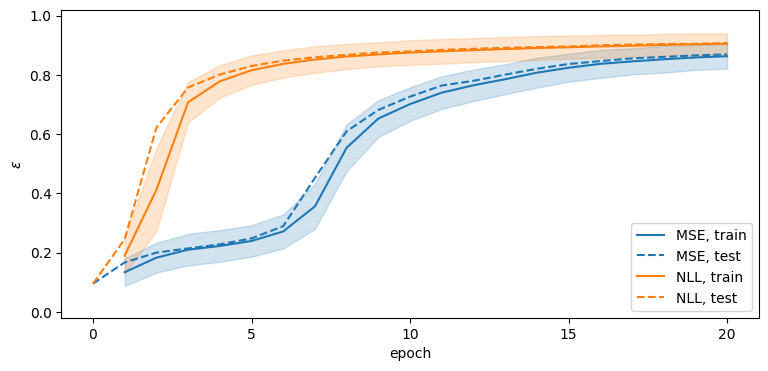

In [32]:
ob_name = 'metric'
ob_label = r'$\epsilon$'

fig, ax = plt.subplots(figsize=(9, 4), nrows=1)

for history, label, color in zip((MSE_history, NLL_history), ('MSE', 'NLL'), ('#1f77b4', '#ff7f0e')):
    tr_history = history['train']
    ax.plot(tr_history['epoch'], tr_history[f'{ob_name}_mean'], color=color, label=f'{label}, train')
    ax.fill_between(tr_history['epoch'], tr_history[f'{ob_name}_mean']-tr_history[f'{ob_name}_std'], tr_history[f'{ob_name}_mean']+tr_history[f'{ob_name}_std'], color=color, alpha=0.2)
    
    te_history = history['test']
    ax.plot(te_history['epoch'], te_history[ob_name], color=color, linestyle='--', label=f'{label}, test')
            
ax.set_ylabel(ob_label)
ax.set_xlabel('epoch')
ax.set_ylim([-0.02, 1.02])
ax.set_xticks([0, 5, 10, 15, 20])
ax.legend(loc='lower right');

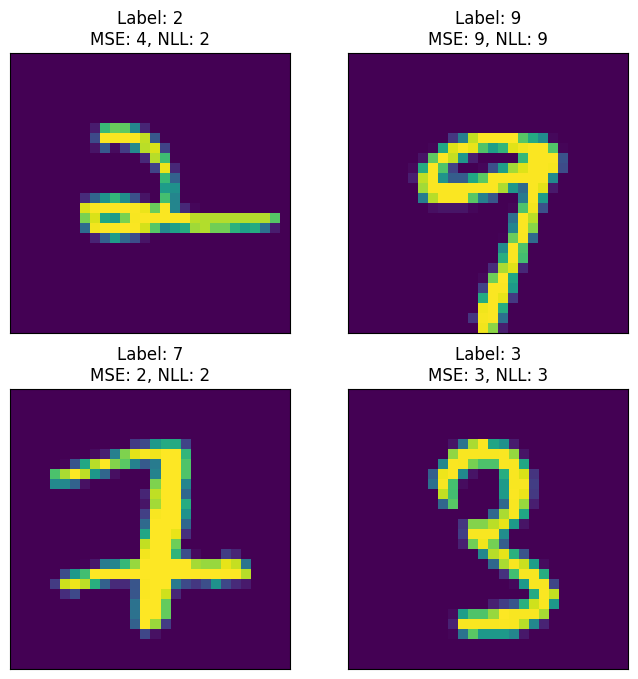

In [33]:
torch.manual_seed(13)

fig, axs = plt.subplots(figsize=(8, 8), ncols=2, nrows=2)
for ax in axs.reshape(-1):
    idx = torch.randint(low=0, high=len(test_dataset), size=(1,))
    img, lab = test_dataset.data[idx], test_dataset.targets[idx].item()
    
    ax.imshow(img[0])

    MSE_cmlp.eval()
    with torch.no_grad():
        output = MSE_cmlp(img.float())
        MSE_lab = output.argmax(dim=-1)

    NLL_cmlp.eval()
    with torch.no_grad():
        output = NLL_cmlp(img.float())
        NLL_lab = output.argmax(dim=-1)

    ax.set_title(f'Label: {lab}\nMSE: {MSE_lab[0]}, NLL: {NLL_lab[0]}')
    ax.set_xticks([])
    ax.set_yticks([])